# Applied Data Science Capstone
*by IBM*


In [1]:
import numpy as np
import pandas as pd
import requests

Using `pandas.read_html` to get a dataframe of the postal code of each neighborhood along with the borough name and neighborhood name

In [3]:
df_codes = pd.read_html('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M')[0]

# Only process the cells that have an assigned borough.
# Ignore cells with a borough that is Not assigned.
df_codes = df_codes[df_codes['Borough'] != 'Not assigned'].reset_index(drop=True)

# If a cell has a borough but a Not assigned  neighborhood,
# then the neighborhood will be the same as the borough.
df_codes['Neighbourhood'] = df_codes.apply(
    lambda x: x['Neighbourhood'] if x['Neighbourhood']!='Not assigned' else x['Borough'],axis=1)

# In order to utilize the Foursquare location data, we need
# to get the latitude and the longitude coordinates of each
# neighborhood.
df_geospatial = pd.read_csv('https://cocl.us/Geospatial_data')

# Joining datasets
df = df_codes.merge(df_geospatial,on="Postal Code",how="left")

In [4]:
from haversine import haversine, Unit

lyon = (45.7597, 4.8422) # (lat, lon)
paris = (48.8567, 2.3508)

haversine(lyon, paris)

392.2172595594006

In [39]:
df_t = df.copy().set_index('Postal Code')




distances = {}
dist_list = []
for i in range(len(df_t)):
    nbh1 = df_t.iloc[i]
    nbh1_pnt = (nbh1['Latitude'],nbh1['Longitude'])
    distances.update({str(nbh1.name):{}})
    
    for j in range(len(df_t)):
        nbh2 = df_t.iloc[j]
        nbh2_pnt = (nbh2['Latitude'],nbh2['Longitude'])
        
        dist = haversine(nbh1_pnt,nbh2_pnt)
        distances[nbh1.name].update({str(nbh2.name):dist})
        
        if i > j:
            dist_list.append(dist)


In [41]:
np.mean(dist_list)

12.075065682807411

In order to utilize the Foursquare location data, we need to get the latitude and the longitude coordinates of each neighborhood. 

In [42]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
import folium 

Insert credentials

In [43]:
CLIENT_ID = 'BELQR33E4XOD32YRUYPSXUVVVR3GTWECQU2TXT1IT2CS10DG' # your Foursquare ID
CLIENT_SECRET = '3CCUNF3DMCFDUTCTIBLUYA0JWVXANW2EQ0R0GV4L5X2UKDFF' # your Foursquare Secret
ACCESS_TOKEN = '3DAFXVUZH2QSV4ARG42A5EATNKI1PODQNMAKUZMI31XZWE25' # your FourSquare Access Token
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: BELQR33E4XOD32YRUYPSXUVVVR3GTWECQU2TXT1IT2CS10DG
CLIENT_SECRET:3CCUNF3DMCFDUTCTIBLUYA0JWVXANW2EQ0R0GV4L5X2UKDFF


Define a function to query the venues for each neighbourhood

In [45]:
def get_nearby_venues(
    postal_code,
    borough,
    neighbourhood,
    latitude,
    longitude,
    radius = 500,
    limit = 100):
            
    # create the API request URL
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION, 
        latitude, 
        longitude, 
        radius, 
        limit)

    results = requests.get(url).json()["response"]['groups'][0]['items']
    
    return [{
        'postal_code': postal_code,
        'borough':borough,
        'neighbourhood':neighbourhood,
        'latitude': latitude,
        'longitude': longitude,
        'name': result['venue']['name'],
        'categories': [cat['name'] for cat in result['venue']['categories']],
#         'categories_full': result['venue']['categories']
        
    } for result in results]

Applying the `get_nearby_venues` to neighbourhoods 

In [82]:
from tqdm import tqdm

list_venues = []

# Get venues for each neighbourhood
for index, row in tqdm(df.iterrows(),total = len(df)):
    results = get_nearby_venues(
        str(row['Postal Code']), 
        str(row['Borough']), 
        str(row['Neighbourhood']), 
        row['Latitude'],
        row['Longitude'],
        radius = 2000,
        limit = 1000
    )
    
    categories = []
    for result in results:
        categories += result['categories']
    
    list_venues.append({
        'postal_code': str(row['Postal Code']),
        'borough': str(row['Borough']),
        'neighbourhood': str(row['Neighbourhood']),
        'latitude': row['Latitude'],
        'longitude': row['Longitude'],
        'categories': pd.Series(categories,name = 'categories').value_counts().to_dict()
    })

100%|██████████| 103/103 [01:37<00:00,  1.06it/s]


Here, I want to write a function to get all possible categories

In [83]:
from functools import reduce
def get_category_values(venues):
    result = list(
        set(
            reduce(
                lambda x,y : x + y,
                [
                    list(venue['categories'].keys()) for venue in venues
                ]
            )
        )
    )
    
    result.sort()
    
    return result
    
category_values = get_category_values(list_venues)

With the categories, It is possible to get the most frequent words on neighbourhood venues

In [84]:
from collections import Counter 

def n_most_common_words(n,venues=list_venues):
        
    list_str = []
    
    for venue in venues:
        try:
            list_str.append(
                reduce(
                    lambda x,y: x+' '+y+' ',
                    [(key+' ')*value for key, value in venue['categories'].items()]
                )
            )

        except:
            pass


    concat_categories = reduce(lambda x,y: x+' '+y+' ',list_str)

    for char in ['/','&']:
        concat_categories = concat_categories.replace(char,'')

    return dict(Counter(concat_categories.split()).most_common(n))

most_common_words = n_most_common_words(250)


Count the words in venues of each neighbourhood

In [85]:
def get_venue_feature_array(venue):

    result = {
        'postal_code': str(venue['postal_code']),
        'borough': str(venue['borough']),
        'neighbourhood': str(venue['neighbourhood']),
        'latitude': venue['latitude'],
        'longitude': venue['longitude'],
    }
    
    result.update(dict([(key,0) for key in most_common_words.keys()]))

    for key, value in venue['categories'].items():
        for word in key.split():
            if word in result.keys(): result[word] += value
                
    return result

venues_array = [get_venue_feature_array(venue) for venue in list_venues]
df_cat = pd.DataFrame(venues_array)

df_cat.head()


,postal_code,borough,neighbourhood,latitude,longitude,Restaurant,Shop,Store,Coffee,Place,Café,Park,Pizza,Italian,Food,Joint,Bar,Sandwich,Bakery,Grocery,Bank,Fast,Gym,Japanese,Pharmacy,Sushi,Station,Chinese,Eastern,Studio,Ice,Beer,American,Middle,Gas,Cream,Liquor,Indian,Clothing,Spot,Theater,Burger,Breakfast,Thai,Supermarket,Hotel,Pub,Vietnamese,Yoga,Market,Brewery,Gastropub,Diner,Home,Dessert,Furniture,Fried,Chicken,Greek,Seafood,Asian,Mexican,Shopping,Tea,Discount,Center,Plaza,Caribbean,Mall,Bookstore,Skating,Rink,Goods,Movie,Korean,Fitness,BBQ,Farmers,Cosmetics,Sporting,French,Ramen,Mediterranean,Vegetarian,Vegan,Sports,Deli,Bodega,Arts,Spa,Burrito,Art,Juice,Convenience,Bubble,Game,Pet,Intersection,Fish,Electronics,Trail,Department,Gallery,Garden,Stadium,Wings,Athletics,Baseball,Dance,Bagel,Hall,Neighborhood,Field,Steakhouse,Museum,Court,Crafts,Dog,Run,Cocktail,Toy,Gourmet,Drink,Golf,Course,Historic,Site,Gift,Salon,Bus,Train,Office,Room,Venue,Concert,Chips,Pool,Turkish,Zoo,Paper,Supplies,Music,Scenic,Lookout,Beach,Men's,Creperie,Club,Health,Taco,Falafel,Exhibit,Playground,Bistro,Flower,Wine,Soccer,Thrift,Vintage,Truck,Poke,Barbershop,Other,Great,Outdoors,Comedy,Tapas,Big,Box,Chocolate,Performing,Space,Service,Jewelry,Line,Flea,Women's,New,Warehouse,Smoothie,Cantonese,Lake,Event,Video,Comic,Basketball,Miscellaneous,Frozen,Yogurt,Latin,Ethiopian,Butcher,Indie,Track,Salad,Hockey,Arena,Botanical,Monument,Landmark,Optical,Persian,Portuguese,Climbing,European,Karaoke,Boutique,Record,Theme,Hardware,Antique,Tennis,Cuban,Harbor,Marina,Bowling,Alley,Cheese,Gay,Pakistani,South,Racetrack,Nail,Baby,Rental,Car,Location,Snack,House,Indonesian,Filipino,Bridal,Farm,Supply,Organic,Hostel,School,Pastry,Bike,Cupcake,Donut,Smoke,Stop,Supplement,General,Entertainment,Noodle,Hakka,Automotive,Kitchen,Doner,Dim,Sum,Beauty,Curling
0,M3A,North York,Parkwoods,43.753259,-79.329656,23,14,11,11,7,2,1,3,1,1,5,1,3,0,1,1,1,3,4,3,1,3,3,1,0,1,1,1,1,3,1,1,0,0,2,0,1,2,1,3,1,0,0,0,0,0,0,1,1,0,1,3,3,1,1,1,0,1,0,3,1,0,2,1,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,2,1,1,0,0,0,0,0,1,0,1,0,0,1,0,1,1,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,2,0,0,0,1,1,0,0,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0
1,M4A,North York,Victoria Village,43.725882,-79.315572,20,15,17,13,5,1,3,1,0,8,2,0,4,1,3,1,7,8,3,2,0,2,1,3,0,1,2,1,3,2,1,1,1,3,1,1,0,0,1,1,0,0,0,0,0,1,0,1,1,0,1,1,1,0,0,0,0,3,0,1,2,1,0,2,0,0,0,0,1,0,2,1,0,0,0,0,0,1,1,1,1,0,0,0,0,0,1,0,0,0,2,0,2,0,0,1,1,1,0,0,0,1,0,0,0,1,0,1,0,1,1,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,18,25,5,20,6,4,4,3,1,2,1,3,1,2,0,0,1,2,0,0,1,0,1,1,0,1,1,2,1,0,1,2,0,2,0,1,1,0,0,0,4,1,0,0,3,0,3,1,0,0,0,0,0,0,1,0,0,1,2,0,2,2,1,1,1,0,0,0,0,0,2,0,3,1,0,2,1,1,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,1,1,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,2,2,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763,27,17,35,7,3,0,0,1,2,5,2,1,1,0,3,3,4,1,1,1,1,0,1,0,0,1,0,3,0,0,1,2,0,9,0,1,0,0,0,0,0,0,5,0,0,1,0,0,4,2,4,2,2,2,1,0,0,1,0,2,1,0,0,1,1,0,0,2,1,0,1,0,0,2,1,0,0,1,0,0,1,0,0,1,0,1,0,1,0,0,1,2,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,1,0,1,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,2,1,1,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

## Clusterization

In [5]:
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score

scaler = MinMaxScaler()


venues_array = [get_venue_feature_array(venue) for venue in list_venues]
df_cat = pd.DataFrame(venues_array)

data = scaler.fit_transform(df_cat.iloc[:,5:])
df_cat.iloc[:,5:] = data

# # run k-means clustering
# kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(df_cat.iloc[:,5:])

results = {
    'k':[],
    'labels': [],
    'davies_bouldin_score':[],
    'inertia':[],
    'silhouette_score':[],
    'calinski_harabasz_score':[],
    'comb_score':[]
}

for kclusters in range(3,20):
    kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(data)
    labels = kmeans.labels_
    
    results['k'].append(kclusters)
    results['labels'].append(labels)
    results['davies_bouldin_score'].append(davies_bouldin_score(data,labels))
    results['inertia'].append(kmeans.inertia_)
    results['silhouette_score'].append(silhouette_score(data,labels))
    results['calinski_harabasz_score'].append(calinski_harabasz_score(data,labels))
    results['comb_score'].append(
        calinski_harabasz_score(data,labels) * silhouette_score(data,labels) / davies_bouldin_score(data,labels)
    )
    
    
    
df_res = pd.DataFrame(results)

# plt.plot(df_res['k'],df_res['comb_score'])

best_comb_score = df_res['comb_score'].max()

df_cat['labels'] = df_res[df_res['comb_score'] == best_comb_score]['labels'].to_list()[0]

colors_list = ['#000000','#3f95d0','#ff0114','#dbb027','#ffa300','#045c5c',]
df_cat['color'] = df_cat['labels'].apply(lambda x: colors_list[x])

NameError: name 'list_venues' is not defined

For each cluster, get the most frequent words

In [216]:
df_gr = df_cat.iloc[:,5:-1].groupby('labels').mean()
resut = []
for lab in df_gr.index:
    list_ven = df_gr.iloc[lab].sort_values(ascending=False)
    list_ind = list_ven.index
    dict_res = {'label': lab}

    for i in range(len(list_ven)): dict_res.update({'word_'+str(i): list_ind[i]})

    resut.append(dict_res)
pd.DataFrame(resut)

,label,word_0,word_1,word_2,word_3,word_4,word_5,word_6,word_7,word_8,word_9,word_10,word_11,word_12,word_13,word_14,word_15,word_16,word_17,word_18,word_19,word_20,word_21,word_22,word_23,word_24,word_25,word_26,word_27,word_28,word_29,word_30,word_31,word_32,word_33,word_34,word_35,word_36,word_37,word_38,word_39,word_40,word_41,word_42,word_43,word_44,word_45,word_46,word_47,word_48,word_49,word_50,word_51,word_52,word_53,word_54,word_55,word_56,word_57,word_58,word_59,word_60,word_61,word_62,word_63,word_64,word_65,word_66,word_67,word_68,word_69,word_70,word_71,word_72,word_73,word_74,word_75,word_76,word_77,word_78,word_79,word_80,word_81,word_82,word_83,word_84,word_85,word_86,word_87,word_88,word_89,word_90,word_91,word_92,word_93,word_94,word_95,word_96,word_97,word_98,word_99,word_100,word_101,word_102,word_103,word_104,word_105,word_106,word_107,word_108,word_109,word_110,word_111,word_112,word_113,word_114,word_115,word_116,word_117,word_118,word_119,word_120,word_121,word_122,word_123,word_124,word_125,word_126,word_127,word_128,word_129,word_130,word_131,word_132,word_133,word_134,word_135,word_136,word_137,word_138,word_139,word_140,word_141,word_142,word_143,word_144,word_145,word_146,word_147,word_148,word_149,word_150,word_151,word_152,word_153,word_154,word_155,word_156,word_157,word_158,word_159,word_160,word_161,word_162,word_163,word_164,word_165,word_166,word_167,word_168,word_169,word_170,word_171,word_172,word_173,word_174,word_175,word_176,word_177,word_178,word_179,word_180,word_181,word_182,word_183,word_184,word_185,word_186,word_187,word_188,word_189,word_190,word_191,word_192,word_193,word_194,word_195,word_196,word_197,word_198,word_199,word_200,word_201,word_202,word_203,word_204,word_205,word_206,word_207,word_208,word_209,word_210,word_211,word_212,word_213,word_214,word_215,word_216,word_217,word_218,word_219,word_220,word_221,word_222,word_223,word_224,word_225,word_226,word_227,word_228,word_229,word_230,word_231,word_232,word_233,word_234,word_235,word_236,word_237,word_238,word_239,word_240,word_241,word_242,word_243,word_244,word_245,word_246,word_247,word_248,word_249
0,0,Place,Sandwich,Pizza,Shop,Restaurant,Pharmacy,Grocery,Joint,Bank,Coffee,Burger,Store,Food,Liquor,Fast,Station,Fried,Chicken,Discount,Supermarket,Gas,Cream,Beer,Japanese,Steakhouse,Goods,Eastern,Middle,Bakery,Sporting,Shopping,Ice,Court,Spot,Park,Breakfast,Warehouse,Mall,Gym,Course,Golf,Department,Convenience,Asian,Toy,Room,American,Vietnamese,Mediterranean,Fish,Movie,Sushi,Office,Gourmet,Arena,Hockey,Game,Fitness,Home,Thai,Furniture,Deli,Bodega,Juice,Turkish,Field,Wings,Caribbean,Electronics,Mexican,Video,Hardware,Chocolate,Center,Pet,Paper,Supplies,Intersection,Indian,Rink,Skating,New,Drink,Pool,Falafel,Tennis,Seafood,Bus,Chinese,Sports,Big,Box,BBQ,Burrito,Theater,Supply,Vintage,Thrift,Entertainment,Latin,General,Playground,Location,Bookstore,Rental,Chips,Bike,Car,Clothing,Italian,Train,Smoothie,Line,Women's,Cosmetics,Event,Bowling,Hakka,Alley,Dessert,Portuguese,Sum,Frozen,Yogurt,Baseball,Automotive,Stop,Kitchen,Hotel,Filipino,Dim,Space,Market,Diner,Trail,Dog,Pub,Run,Cantonese,Bar,Tea,Spa,Athletics,Café,Pakistani,Health,Bridal,Climbing,Jewelry,Crafts,Hall,Arts,Service,Brewery,Greek,Salad,Persian,Karaoke,Supplement,French,Cupcake,Curling,Track,Garden,Flea,Bistro,Museum,Bubble,Bagel,Studio,Outdoors,Great,Other,Soccer,House,Korean,Music,Boutique,Racetrack,Antique,Baby,Beauty,Salon,Men's,Butcher,Pastry,Club,Botanical,Cheese,Indie,Flower,Noodle,Optical,Ramen,Truck,Barbershop,Smoke,Yoga,Gastropub,Tapas,Marina,Harbor,Plaza,European,Creperie,Donut,Farm,Miscellaneous,Taco,Exhibit,Theme,Zoo,Gallery,Poke,Basketball,Vegetarian,Vegan,Gift,Doner,Comedy,Farmers,Stadium,Art,Dance,South,Site,Historic,Neighborhood,Beach,Venue,Cocktail,Concert,Monument,Lake,Comic,Cuban,Nail,Landmark,Ethiopian,School,Hostel,Performing,Snack,Indonesian,Scenic,Lookout,Gay,Record,Organic,Wine
1,1,Club,Comedy,Gallery,Neighborhood,Landmark,Lake,Monument,Stad

Plotting the clusters

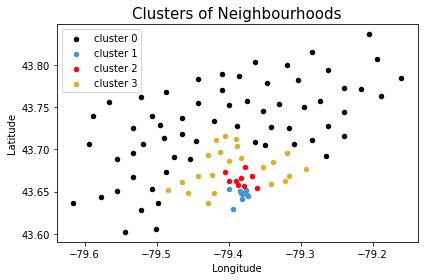

In [217]:
import matplotlib.pyplot as plt
for lab in  np.sort(df_cat['labels'].unique()):
    df_plot = df_cat[df_cat['labels']==lab]
    plt.scatter(df_plot['longitude'],df_plot['latitude'],c=colors_list[lab],s=20,label='cluster '+str(lab))
    
plt.legend()
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Clusters of Neighbourhoods', fontsize=15)
plt.tight_layout()
plt.savefig('clusters_of_neighbourhood.png')
plt.show()

Plotting the Map

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


In [219]:
import random
from IPython.core.display import display, HTML


address = 'Toronto'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

# create map of New York using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)


# add markers to map
for (lat, lng, borough, neighborhood,lab,col) in zip(df_cat['latitude'], df_cat['longitude'], df_cat['borough'], df_cat['neighbourhood'], df_cat['labels'], df_cat['color']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=col,
        fill=True,
        fill_color=col,
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  

file = 'map.html'

map_toronto.save(file)
display(HTML('<a href="'+file+ '" target="_blank">Click here to see the map.</a>'))

map_toronto

In [234]:
import pycep_correios
from geopy.geocoders import Nominatim

# R. Dragão do Mar, 81 - Praia de Iracema, Fortaleza - CE, 60060-390
endereco = pycep_correios.get_address_from_cep('37704100')

geolocator = Nominatim(user_agent="test_app")
location = geolocator.geocode(endereco['logradouro'] + ", " + endereco['cidade'] + " - " + endereco['bairro'])

# print(location.latitude, location.longitude)

In [236]:
Nominatim(user_agent="test_app")

In [232]:
pycep_correios.get_address_from_cep('37704001')

{'bairro': 'Jardim São Paulo',
 'cep': '37704-001',
 'cidade': 'Poços de Caldas',
 'logradouro': 'Rua Fanny de Carvalho Prata - de 274/275 ao fim',
 'uf': 'MG',
 'complemento': ''}

In [279]:
from geopy.geocoders import Nominatim


geolocator = Nominatim(user_agent="test_app")
location = geolocator.geocode( 'Rio de Janeiro' + " - " + 'Realengo')


In [20]:
import pandas as pd
import numpy as np
import re
import requests 
import folium
from bs4 import BeautifulSoup
from html import unescape
from tqdm import tqdm
from geopy.geocoders import Nominatim
from functools import reduce
from collections import Counter 


def scrap_neighbourhoods_from_guiamais(url):
    """Scraps the neighbourhoods list of a city from
    a given url of guiamais.com.br site.
    """

    table = BeautifulSoup(requests.get(url).text, "lxml").find(
        "section", class_="cities centerContent"
    )

    table_string = unescape(str(table.find_all("li")))

    return re.findall('">(.*?)</a', table_string)


def neighbourhood_dataframe(city, neighbourhood_list):
    """ Trasform a list of neighbourhood into dataframe  """
    return pd.DataFrame(
        [(city, nb) for nb in neighbourhood_list], columns=["city", "neighbourhood"]
    )


def get_neighbourhood_coord(nominatim, city, neighbourhood):
    """ Gets the coordinate of a neighbourhood """
    
    try:
        location = nominatim.geocode(neighbourhood + " - " + city + ", Brazil")
        return (location.latitude, location.longitude)

    except Exception as inst:
#         print(inst)
        return (None, None)


# Define here the cities and its respectives urls to
# scrap the neighbourhood list
cities = {
    'rj': {
        'name': 'Rio de Janeiro',
        'url':'https://www.guiamais.com.br/bairros/rio-de-janeiro-rj',
        'long_min': -43.694087,
        'long_max': -43.166904,
        'lat_min': -23.047039,
        'lat_max': -22.785521,
    },
    'sp':{
        'name': 'São Paulo',
        'url':'https://www.guiamais.com.br/bairros/sao-paulo-sp',
        'long_min': -46.860478,
        'long_max': -46.137922,
        'lat_min': -23.850532,
        'lat_max': -23.385265,
    },
#     'pc': {
#         'name': 'Poços de Caldas',
#         'url':'https://www.guiamais.com.br/bairros/pocos-de-caldas-mg'
#     },
}

# Scrapes neighbourhood and creates a pandas dataframe with the result
df = pd.concat(
    [
        neighbourhood_dataframe(
                cities[_]['name'],
                scrap_neighbourhoods_from_guiamais(cities[_]['url'])    
        )  for _ in cities
    ]
).reset_index(drop=True)

In [3]:
if False:

    # instantiate the Nominatim class
    geoloc = Nominatim(user_agent="test_app")

    # Gets the coordinates of all neighbourhoods
    coord_list = [
        get_neighbourhood_coord(geoloc,row['city'],row['neighbourhood']) 
         for index, row in tqdm(df.iterrows(),total = len(df))
    ]

    # Adds the coordinates to neighbourhoods dataframe
    df = pd.concat(
        [
            df,
            pd.DataFrame(coord_list,
                columns=['latitude','longitude'])
        ],
        axis=1
    )

    # Exports the result
    df.to_csv(
        'data/coord'+reduce(lambda x,y: '_'+x+'_'+y,[_ for _ in cities])+'.csv',
        index=False
    )


In [4]:
# Import the dataframe of neighbourhood
df = pd.read_csv( 'data/coord'+reduce(lambda x,y: '_'+x+'_'+y,[_ for _ in cities])+'.csv')

# Removes index column
if 'index' in df.columns: df.drop(columns=['index'],inplace=True)
    
df = df.reset_index()

# Remove all neighbourhoods without coordinates
df = df.dropna()

df.drop(index=df[(df['neighbourhood']=='Campos Elíseos') & (df['city']=='São Paulo')].index[0],inplace=True)

In [5]:
CLIENT_ID = 'BELQR33E4XOD32YRUYPSXUVVVR3GTWECQU2TXT1IT2CS10DG' # your Foursquare ID
CLIENT_SECRET = '3CCUNF3DMCFDUTCTIBLUYA0JWVXANW2EQ0R0GV4L5X2UKDFF' # your Foursquare Secret
ACCESS_TOKEN = '3DAFXVUZH2QSV4ARG42A5EATNKI1PODQNMAKUZMI31XZWE25' # your FourSquare Access Token
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

def get_nearby_venues(index,
                      city,
                      neighbourhood,
                      latitude,
                      longitude,
                      radius = 1500,
                      limit = 1000):
    """ Query to explore the neighbourhood places in foursquare api """
            
    # create the API request URL
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION, 
        latitude, 
        longitude, 
        radius, 
        limit)

    try:
        results = requests.get(url, timeout=5).json()["response"]['groups'][0]['items']
    
        return [{
            'index': index,
            'city': city,
            'neighbourhood':neighbourhood,
            'latitude': latitude,
            'longitude': longitude,
            'name': result['venue']['name'],
            'categories': [cat['name'] for cat in result['venue']['categories']],
            # 'categories_full': result['venue']['categories']

        } for result in results]

    except:
        return [{
            'index': index,
            'city': city,
            'neighbourhood':neighbourhood,
            'latitude': latitude,
            'longitude': longitude,
            'name': None,
            'categories': [None],
        }]

Your credentails:
CLIENT_ID: BELQR33E4XOD32YRUYPSXUVVVR3GTWECQU2TXT1IT2CS10DG
CLIENT_SECRET:3CCUNF3DMCFDUTCTIBLUYA0JWVXANW2EQ0R0GV4L5X2UKDFF


In [6]:
if False:
    
    # Gets the venues for all neighbourhoods
    venue_list = [
        get_nearby_venues(
            row['index'],
            row['city'],
            row['neighbourhood'],
            row['latitude'],
            row['longitude'],
            radius = 1500,
            limit = 1000
        )

        for index, row in tqdm(df.iterrows(),total = len(df))
    ]
    
    venue_list = reduce(lambda x,y: x+y,venue_list)
    
    df_venues = pd.DataFrame(venue_list)

    df_venues.to_csv(
        'data/venues'+reduce(lambda x,y: '_'+x+'_'+y,[_ for _ in cities])+'.csv',
        index=False
    )
    
    
df_venues = pd.read_csv('data/venues'+reduce(lambda x,y: '_'+x+'_'+y,[_ for _ in cities])+'.csv')


def check_coord(row):
    
    list_check = []
    for key in cities:
        city = cities[key]
        
        cond = True
        cond &= row['city'] == city['name']
        cond &= row['latitude'] >= city['lat_min']
        cond &= row['latitude'] <= city['lat_max']
        cond &= row['longitude'] >= city['long_min']
        cond &= row['longitude'] <= city['long_max']
        
        cond &= pd.notnull(row['name'])
        
        list_check.append(cond)
        
    return any(list_check)
        
    
df_venues = df_venues[df_venues.apply(lambda row: check_coord(row),axis=1)]

if 'index' in df_venues.columns:
    df_venues.drop(columns=['index'], inplace=True)

df_venues['categories'] = df_venues['categories'].apply(
    lambda x: ' '.join(
        x[1:-1].replace("'","").split(',')
    ).replace('/','').replace('&','').replace('  ',' ')
)

df_venues = pd.merge(
    df_venues, 
    df[['index','city','neighbourhood']],  
    how='left', left_on=['city','neighbourhood'], right_on = ['city','neighbourhood'])

df_venues.rename(columns={'index':'neighbourhood_id'},inplace=True)

venue_list = df_venues.to_dict('records')

In [7]:
def n_most_common_words(categories,n=None):
    
    words_list = ' '.join(categories)

#     words_list = reduce(
#         lambda x,y: x+' '+y+' ',
#         reduce(
#             lambda x,y: x+y,
#             list(categories)
#         )
#     )

    for char in ['/','&']:
        words_list = words_list.replace(char,'')

    
    if n:
        result =  dict(Counter(words_list.split()).most_common(n))
    
    else:
        result =  dict(Counter(words_list.split()).most_common())
        
    return result
  
most_common_words = n_most_common_words(df_venues['categories'])
   
len(most_common_words)

506

In [8]:
def concat_categories(series):
       return reduce(lambda x, y: x +' '+y, series)

    
df_categories = df.merge(
    df_venues.groupby('neighbourhood_id').agg({'categories':  concat_categories}),
    left_on = 'index',
    right_index = True
).rename(columns={'index':'neighbourhood_id'})


# Creates columns for categories 
for word in most_common_words:
    df_categories[word] = 0
    
total_dict = dict([(
    neighbourhood_id, 
    np.sum(
        [
            val if key in most_common_words else 0 
            for key,val in Counter(cat.split()).most_common()
        ]
    )
) for neighbourhood_id, cat in df_categories['categories'].to_dict().items()])

    
for ind, row in tqdm(df_categories.iterrows(),total=len(df_categories)):
    for word in row['categories'].split(' '):
        if word in most_common_words:
            df_categories.loc[df_categories['neighbourhood_id']==row['neighbourhood_id'],word] += 1/total_dict[row['neighbourhood_id']]
            
df_categories.set_index('neighbourhood_id',inplace=True)

df_categories

100%|██████████| 566/566 [02:17<00:00,  4.12it/s]


,city,neighbourhood,latitude,longitude,categories,Restaurant,Store,Shop,Place,Gym,...,Information,Temple,Donburi,Non-Profit,Hospital,Taiwanese,Luggage,Israeli,Fair,Distribution
neighbourhood_id,,,,,,,,,,,,,,,,,,,,,
0,Rio de Janeiro,Abolição,-22.886161,-43.299846,Deli Bodega Restaurant Portuguese Restaurant F...,0.095745,0.031915,0.010638,0.053191,0.042553,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
1,Rio de Janeiro,Acari,-22.822153,-43.340674,Restaurant Flea Market Sandwich Place Warehous...,0.076923,0.089744,0.025641,0.038462,0.012821,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
2,Rio de Janeiro,Água Santa,-22.911143,-43.312126,Arts Entertainment Gym Bakery Bar Soccer Field...,0.000000,0.055556,0.000000,0.000000,0.111111,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
3,Rio de Janeiro,Alto da Boa Vista,-22.962113,-43.253582,Scenic Lookout Scenic Lookout River Athletics ...,0.000000,0.000000,0.000000,0.000000,0.125000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
4,Rio de Janeiro,Anchieta,-22.823190,-43.399107,Fast Food Restaurant Church Gym Gastropub Pizz...,0.067416,0.011236,0.011236,0.067416,0.044944,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1359,São Paulo,Riviera Paulista,-23.555371,-46.662979,Cultural Center Church Multiplex Brazilian Res...,0.174157,0.033708,0.067416,0.022472,0.028090,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
1361,São Paulo,Sacomã,-23.601282,-46.602555,Restaurant Department Store Bar Sports Bar Per...,0.108696,0.032609,0.097826,0.059783,0.032609,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
1363,São Paulo,Santa Cecília,-23.529660,-46.651894,Dive Bar Health Food Store Farmers Market Kore...,0.108808,0.041451,0.046632,0.036269,0.031088,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.005181,0.000000,0.000000


In [9]:
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score

scaler = MinMaxScaler()


try:
    df_categories.drop(columns = ['labels','color'],inplace=True)
except:
    pass


df_cluster = df_categories.copy()

try:
    df_cluster.drop(
        columns=['Restaurant','Shop','Store','Bakery','Food'],
        inplace=True)
except:
    pass


data = df_cluster.iloc[:,5:]
data = scaler.fit_transform(data)


results = {
    'param':[],
    'labels': [],
    'davies_bouldin_score':[],
#     'inertia':[],
    'silhouette_score':[],
    'calinski_harabasz_score':[],
    'comb_score':[]
}




for par in np.arange(3,7,1):
# for par in np.arange(1.7,1.71,0.1):
    clustering = KMeans(n_clusters=int(par)).fit(data)
#     clustering = DBSCAN(eps = par,min_samples = 5).fit(data)
    labels = clustering.labels_
    results['param'].append(par)
    results['labels'].append(labels)
    results['davies_bouldin_score'].append(davies_bouldin_score(data,labels))
#     results['inertia'].append(clustering.inertia_)
    results['silhouette_score'].append(silhouette_score(data,labels))
    results['calinski_harabasz_score'].append(calinski_harabasz_score(data,labels))
    results['comb_score'].append(
        calinski_harabasz_score(data,labels) * silhouette_score(data,labels) / davies_bouldin_score(data,labels)
    )
    
    
    
df_res = pd.DataFrame(results)


best_comb_score = df_res['comb_score'].max()

df_cluster['labels'] = df_res[df_res['comb_score'] == best_comb_score]['labels'].to_list()[0]

number_of_colors = 8

colors_list = ['#000000','#3f95d0','#ff0114','#dbb027','#045c5c','#ffa300',]

df_cluster['color'] = df_cluster['labels'].apply(lambda x: colors_list[x])

In [10]:
df_gr = df_cluster.iloc[:,5:-1].groupby('labels').mean()

resut = []
for lab in df_gr.index:
    list_ven = df_gr.iloc[lab].sort_values(ascending=False)
    list_ind = list_ven.index
    dict_res = {'label': lab}

    for i in range(len(list_ven)): dict_res.update({'word_'+str(i): list_ind[i]})

    resut.append(dict_res)
pd.DataFrame(resut).T.head(20)

,0,1,2
label,0,1,2
word_0,Gym,Gym,Bar
word_1,Place,Place,Brazilian
word_2,Bar,Pizza,Place
word_3,Pizza,Center,Center
word_4,Brazilian,Fitness,Gym
word_5,Joint,Brazilian,Italian
word_6,Center,Joint,Coffee
word_7,Fitness,Market,Theater
word_8,Burger,Bar,Japanese


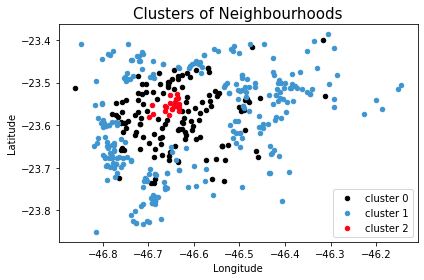

In [19]:
import matplotlib.pyplot as plt
import numpy as np

city = cities['sp']

conditions = df_cluster['city'] == city['name']
conditions &= (df_cluster['latitude'] > city['lat_min']) & (df_cluster['latitude'] < city['lat_max'])
conditions &= (df_cluster['longitude'] > city['long_min']) & (df_cluster['longitude'] < city['long_max'])
df_cat = df_cluster[conditions]

for lab in  np.sort(df_cat['labels'].unique()):
    df_plot = df_cat[df_cat['labels']==lab]
    plt.scatter(df_plot['longitude'],df_plot['latitude'],c=colors_list[lab],s=20,label='cluster '+str(lab))
    
plt.legend()
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Clusters of Neighbourhoods', fontsize=15)
plt.tight_layout()
plt.savefig('clusters_of_neighbourhood.png')
plt.show()

In [12]:
import random
from IPython.core.display import display, HTML


geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(city['name'])
latitude = location.latitude
longitude = location.longitude

# create map of New York using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)


# add markers to map
for (lat, lng, neighborhood,lab,col) in zip(df_cat['latitude'], df_cat['longitude'], df_cat['neighbourhood'], df_cat['labels'], df_cat['color']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=col,
        fill=True,
        fill_color=col,
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  

file = 'map.html'

map_toronto.save(file)
display(HTML('<a href="'+file+ '" target="_blank">Click here to see the map.</a>'))

map_toronto

In [15]:
df_crime = pd.read_csv('data/BO_2016.csv',low_memory=False)

In [370]:

cond = True
cond &= df_crime['city'] == city['name']
cond &= df_crime['latitude'] >= city['lat_min']
cond &= df_crime['latitude'] <= city['lat_max']
cond &= df_crime['longitude'] >= city['long_min']
cond &= df_crime['longitude'] <= city['long_max']
        

,index,city,neighbourhood,latitude,longitude
163,163,Rio de Janeiro,Tubiacanga,-22.785521,-43.226517


In [371]:
df[df['neighbourhood'] == 'Grumari']

,index,city,neighbourhood,latitude,longitude
69,69,Rio de Janeiro,Grumari,-23.047039,-43.533479
